In [1]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]
from matplotlib.pyplot import imshow

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

from utils.data_utils import *

In [2]:
df_train = pd.read_csv('inputs/train_v2.csv')
labels, label_map, inv_label_map = get_labels()
np.array(labels)

array(['slash_burn', 'clear', 'blooming', 'primary', 'cloudy',
       'conventional_mine', 'water', 'haze', 'cultivation',
       'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground',
       'blow_down', 'agriculture', 'road', 'selective_logging'],
      dtype='|S17')

In [3]:
X, Y = load_data(df_train, 'inputs/train-jpg', label_map, img_size=128)
print(X.shape)

100%|██████████| 40479/40479 [00:43<00:00, 935.09it/s]

Creating numpy array for data...
(40479, 128, 128, 3)


In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=0)

In [98]:
benchmark_model0 = np.random.uniform(size = Y_valid.size).reshape(Y_valid.shape)
benchmark_model0 = (benchmark_model0 > 0.5).astype(int)
score = fbeta_score(Y_valid, benchmark_model0, beta=2, average='samples')
print("Benchmark model0 F-beta score %.5f" % score)

Benchmark model0 F-beta score 0.33850


In [22]:
def get_probs(y):
    probs = np.empty(y.shape[1])
    for i in range(y.shape[1]):
        probs[i] = float(np.sum(y[:,i]))/y.shape[0]
    return probs

In [93]:
get_probs(Y_train)

array([ 0.00481734,  0.70215854,  0.00818331,  0.92650465,  0.05252756,
        0.00234691,  0.18361486,  0.06685607,  0.11005775,  0.17842695,
        0.00843035,  0.09041781,  0.02068987,  0.00256307,  0.30525276,
        0.19880802,  0.00818331])

In [28]:
model_probs = get_probs(Y_train)

In [97]:
benchmark_model1 = np.empty(Y_valid.shape)
for i in range(Y_valid.shape[1]):
    temp = np.random.uniform(size = Y_valid.shape[0])
    benchmark_model1[:,i] = (temp < model_probs[i]).astype(int)
score = fbeta_score(Y_valid, benchmark_model1, beta=2, average='samples')
print("Benchmark model1 F-beta score %.5f" % score)

Benchmark model1 F-beta score 0.56052


In [62]:
def get_benchmark2(threshold, shape, model_probs):
    benchmark_model2 = np.empty(shape)
    for i in range(shape[1]):
        if model_probs[i] < threshold:
            benchmark_model2[:,i] = 0
        else:
            benchmark_model2[:,i] = 1
    return benchmark_model2

In [71]:
thresholds = np.arange(50)/100. + 0.01
thresholds

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
        0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,
        0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,
        0.46,  0.47,  0.48,  0.49,  0.5 ])

In [89]:
train_scores = []
for th in tqdm(thresholds):
    benchmark_model2 = get_benchmark2(th, Y_train.shape, model_probs)
    score = fbeta_score(Y_train, benchmark_model2, beta=2, average='samples')
    train_scores.append(score)

100%|██████████| 50/50 [00:01<00:00, 26.26it/s]


In [90]:
valid_scores = []
for th in tqdm(thresholds):
    benchmark_model2 = get_benchmark2(th, Y_valid.shape, model_probs)
    score = fbeta_score(Y_valid, benchmark_model2, beta=2, average='samples')
    valid_scores.append(score)

100%|██████████| 50/50 [00:00<00:00, 88.77it/s]


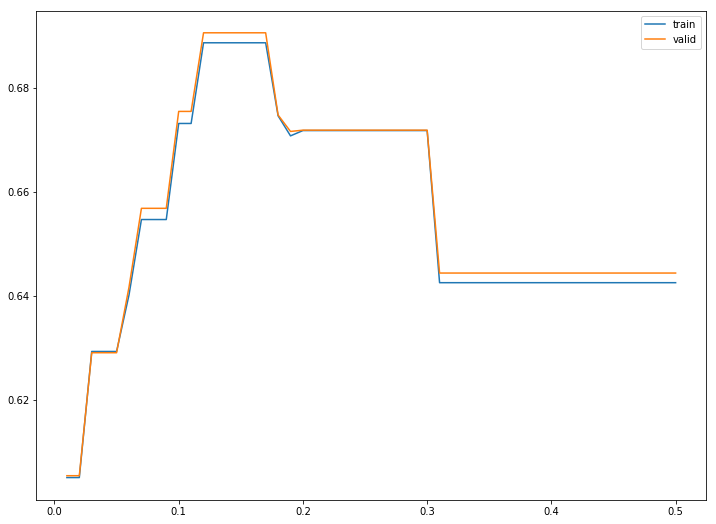

In [92]:
plt.plot(thresholds, train_scores)
plt.plot(thresholds, valid_scores)
plt.legend(['train', 'valid'])

In [96]:
benchmark_model2 = get_benchmark2(0.15, Y_valid.shape, model_probs)
score = fbeta_score(Y_valid, benchmark_model2, beta=2, average='samples')
print("Benchmark model2 F-beta score %.5f" % score)

Benchmark model2 F-beta score 0.69054
